# Visualize Target Approach

This notebook works for VR target approach experiments where the 2D and 3D stimuli are interleaved (after April 13, 2021)

In [1]:
import os
import sys
import h5py

import pandas as pd
import numpy as np
import panel as pn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm.notebook import tqdm
from scipy.stats import sem
from datetime import datetime

sys.path.insert(0, r'..\..')
import paths
import functions_bondjango as bd
import functions_kinematic as fk
import functions_plotting as fp
import functions_preprocessing as fpr
import functions_misc as fm
import functions_data_handling as fd
import functions_vrtarget as vt


import importlib
importlib.reload(vt)

line_width = 5
matplotlib.rcParams.update({'font.size': 22})

In [2]:
def thresh_function(param, thres):
    return param <= thres

In [3]:
def get_count_mean_sem(df: pd.DataFrame, grouping_params: list, target_param: str) -> pd.DataFrame:
    grouped = df.groupby(['date', *grouping_params])[target_param]
    count = grouped.sum().reset_index()
    mean = count.groupby([*grouping_params])[target_param].mean().unstack().T
    sem = count.groupby([*grouping_params])[target_param].sem().unstack().T

    return count, mean, sem

In [4]:
def get_percentage_trials(df: pd.DataFrame, grouping_params: list, target_param: str) -> pd.DataFrame:
    new_col_name = 'percent_{}'.format(target_param)

    grouped = df.groupby(['date', *grouping_params])[target_param]
    
    percent = 100 * grouped.sum() / grouped.count()
    percent = percent.reset_index()
    percent = percent.rename(columns={target_param: new_col_name})
    
    mean_percent = percent.groupby([*grouping_params])[new_col_name].mean().unstack().T
    sem_percent = percent.groupby([*grouping_params])[new_col_name].sem().unstack().T


    return percent, mean_percent, sem_percent

In [5]:
def plot_approach_heatmaps_by_contrast(df, level=0, fig=None, axes=None, **kwargs):
    colors = df.groupby(level=[level]).agg(list).index.to_list()
    color_labels = {'(0, 0, 0, 1)': '100% black',
                    '(0.25, 0.25, 0.25, 1)': '75% gray',
                    '(1, 1, 1, 1)': '0% white',
    }

    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(10, 20), constrained_layout=True)

    images = []
    cmap_max = kwargs.get('cmap_max', None)
    
    if cmap_max is None:
            cmap_max = df.values.max()
            kwargs['cmap_max'] = cmap_max
    
    for i, color in enumerate(colors):
        ax = axes[i]
        data = df.xs(color, level=level)
        values = data.values
        speeds = [int(a) for a in data.index.to_list()]
        scales = data.columns.to_list()
        
        im, ax = fp.plot_heatmap(values, scales, speeds, ax=ax, **kwargs)
        images.append(im)
        
        axes[i].set_ylabel('Speeds [cm/s]')
        axes[i].set_xlabel("Scale [cm]")
        
        if 'date' in kwargs:
            axes[i].set_title('{}\nContrast: {}'.format(kwargs.get('date'), color_labels[str(color)]))
        elif 'nbin' in kwargs:
            axes[i].set_title('Bin: {}\nContrast: {}'.format(str(int(kwargs.get('nbin'))), color_labels[str(color)]))
        elif 'target_type' in kwargs:
            axes[i].set_title('Dimension: {}\nContrast: {}'.format(str(kwargs.get('target_type')), color_labels[str(color)]))
        elif ('date' in kwargs) and ('target_type' in kwargs):
            axes[i].set_title('{} \nDimension: {}, Contrast: {}'.format(kwargs.get('date'), str(kwargs.get('target_type')), color_labels[str(color)]))
        elif ('nbin' in kwargs) and ('target_type' in kwargs):
            axes[i].set_title('Bin:{} \nBin: {}, Contrast: {}'.format(str(int(kwargs.get('nbin'))), str(kwargs.get('target_type')), color_labels[str(color)]))
        else:
            axes[i].set_title('Contrast: {}'.format(color_labels[str(color)]))
        
    if i+1 <= len(axes):
        for ax in axes[i+1:]:
            ax.set_visible(False)

    return fig, axes, images

In [6]:
# define the name to be used for the saved figures
notes = 'led100'
save_name = 'VScreen_{}'.format(notes)

In [ ]:
# If this data set was already processed
approach_df = pd.read_hdf(r"D:/vscreens/" + save_name, 'data')

In [7]:
search_params = {'result': 'test',
                 'lighting': 'normal',
                 'rig': 'VScreen',
                 'analysis_type': 'preprocessing',
                 'gtdate': '2021-03-22T00-00-00',
                 'notes': notes
                }

search_string = ', '.join("{}:{}".format(key,val) for (key,val) in search_params.items())
data = vt.load_VScreens_datasets(search_string, exclusion="removedtracker")

04_20_2021_15_05_20_vscreen_dg_210203_b_test_led100_lts60_startclose_preprocessing
04_20_2021_14_07_41_vscreen_dg_210203_a_test_led100_lts60_startclose_preprocessing
04_20_2021_13_05_22_vscreen_dg_210202_b_test_led100_lts60_startclose_preprocessing
04_20_2021_11_58_38_vscreen_mm_210303_b_test_led100_lts60_startclose_long_preprocessing
04_20_2021_10_44_57_vscreen_mm_210303_a_test_led100_lts60_startclose_long_preprocessing
04_19_2021_15_33_11_vscreen_mm_210303_b_test_led100_lts60_startclose_preprocessing
04_19_2021_14_32_47_vscreen_dg_210202_b_test_led100_lts60_startclose_preprocessing
04_19_2021_13_19_52_vscreen_dg_210203_a_test_led100_lts60_startclose_preprocessing
04_19_2021_11_36_17_vscreen_dg_210203_b_test_led100_lts60_startclose_preprocessing
04_16_2021_15_53_33_vscreen_dg_210203_b_test_led100_lts60_startclose_preprocessing
04_16_2021_14_48_56_vscreen_dg_210203_a_test_led100_lts60_startclose_preprocessing
04_16_2021_13_47_58_vscreen_dg_210202_b_test_led100_lts60_startclose_preproce

In [8]:
exp_manipulation_params = ['object', 'color_target', 'scale', 'speed']
df_columns = ['date', 'animal', 'bin', 'trial_num', 'target_type', 'target_color', 'speed', 'scale', 'approaches', 'has_approach']

# encounter_criteria
approach_criteria = {'2D': {'distance_threshold':0.05, 'speed_minimum': 0.10, 'start_distance': 0.05, 'window': 2},
                     '3D': {'distance_threshold':0.10, 'speed_minimum': 0.10, 'start_distance': 0.05, 'window': 2},
                     'cricket': {'distance_threshold':0.10, 'speed_minimum': 0.10, 'start_distance': 0.05, 'window': 2}
                     }

# This lookup list matches the target types as defined in the Unity scene
target_lookup = ['2D', '2D', '2D', '3D', '3D', '3D', 'cricket']

In [95]:
# Get the mean trial duration for the fastest stimulus speed in the data set
fast_trials = data[0]['trial_params']['trial_num'][data[0]['trial_params']['speed'] == data[0]['trial_params']['speed'].max()].to_numpy()
fast_bois = [data[0]['traces'].loc[data[0]['traces']['trial_num'] == x] for x in fast_trials]

durations = []
for fb in fast_bois:
    time_moving = fb['time_vector'][(fb['target_speed'] > 0.1) & (fb['target_speed'] < 0.4)].to_numpy()
    durations.append(time_moving[-1] - time_moving[1])
    
# This time will be how we create pseudotrials from the longer data sets
pseudo_duration = np.mean(durations)

In [92]:
slow_trials = data[0]['trial_params']['trial_num'][data[0]['trial_params']['speed'] == data[0]['trial_params']['speed'].min()].to_numpy()
slow_bois = [data[0]['traces'].loc[data[0]['traces']['trial_num'] == x] for x in slow_trials]

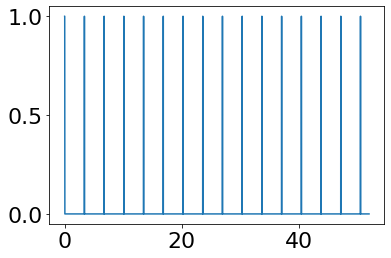

In [106]:
t = slow_bois[0]['time_vector'].to_numpy()
t -= t[0]
a = t % pseudo_duration
plt.plot(t, a < 0.01)

In [ ]:
def make_pseudo_trials_by_speed(traces, exp_params, duration):
    """Breaks up a longer trial with a slower stimulus into pseudo trials 
    with a duration that equals the trial duration of the fastest stimulus. """
    

In [ ]:
# For later visualization
all_valid_approaches = []
all_approaches = []

test_ds = data[0:1]

# Make a new data frame
approach_df = pd.DataFrame(columns=df_columns)

for exp_num, exp in tqdm(enumerate(test_ds), total=len(test_ds)):
    
    # Add experiment number
    exp['traces']['experiment_num'] = exp_num
    
    # For older experiments, add a target type column so that it is compatible with newer data sets
    if 'object' not in exp['trial_params'].columns:
        if '2D' in notes:
            exp['trial_params']['object'] = 0
            # To be removed once incorporated into snakemake preprocessing
#             exp['traces'] = vt.recalculate_2D_target_mouse_distance(exp['traces'])
        elif '3D' in notes:
            exp['trial_params']['object'] = 3
#             exp['traces'] = vt.recalculate_3D_target_mouse_distance(exp['traces'])
    
    # Check if the experiment ended early and only consider the completed trials
    exp = vt.remove_trials_end_early(exp)

    # Extract the approaches in this experiment
    experiment_approaches = pd.DataFrame(columns=df_columns)
    experiment_approaches, exp_valid_approaches, all_exp_approaches = \
        vt.extract_experiment_approaches(exp, exp_manipulation_params, 'target_mouse_distance_adj', thresh_function, 
                                         approach_criteria, experiment_approaches)
    
    approach_df = approach_df.append(experiment_approaches, ignore_index=True)
    all_valid_approaches.append(exp_valid_approaches)
    all_approaches.append(all_exp_approaches)
                             
# Save the data for later
approach_df.to_hdf(r"D:/vscreens/" + save_name, 'data')

# Collect some parameters from all of the experiments for further analysis
all_traces_df = pd.concat([exp['traces'][['date', 'animal', 'experiment_num', 'bins', 'trial_num', 'mouse_distance_travelled', 'mouse_x_m', 'mouse_y_m']] for exp in data])

In [ ]:
# label dates as unique for groupby later
sorted_date = np.sort(approach_df['date'].unique())
day = np.zeros(len(approach_df['date']))
for d in approach_df['date'].unique():
    which_day = np.where(sorted_date == d)[0][0]
    day = np.where(approach_df['date'] == d, which_day, day)
    
approach_df['day'] = day

In [ ]:
# label dates as unique for groupby later
sorted_date = np.sort(all_traces_df['date'].unique())
day = np.zeros(len(all_traces_df['date']))
for d in all_traces_df['date'].unique():
    which_day = np.where(sorted_date == d)[0][0]
    day = np.where(all_traces_df['date'] == d, which_day, day)
    
all_traces_df['day'] = day

In [ ]:
# Locomotion of all mice on first day

a = all_traces_df.loc[all_traces_df['day'] == 0].groupby(['animal', 'bins'])['mouse_distance_travelled'].sum()
dist_tr = a.groupby(['bins']).mean()
bins = list(dist_tr.index)
plt.bar(bins, dist_tr.to_numpy())
plt.xlabel('Bin')
plt.ylabel('Total distance travelled [m]')
plt.title('Mean distance travelled per bin across experiments')

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'dist_travelled_bins']))
plt.savefig(save_path)

In [ ]:
# locomotion of all mice on all days
# Note here we use experiment_num instead of animal since we have multiple repetitions of each animal
a = all_traces_df.groupby(['experiment_num', 'bins'])['mouse_distance_travelled'].sum()
dist_tr = a.groupby(['bins']).mean()
bins = list(dist_tr.index)
plt.bar(bins, dist_tr.to_numpy())
plt.xlabel('Bin')
plt.ylabel('Total distance travelled [m]')
plt.title('Mean distance travelled per bin across experiments')

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'dist_travelled_bins']))
plt.savefig(save_path)

In [ ]:
# Dwell time of all mice on first day during trials

data = all_traces_df.loc[all_traces_df['day'] == 0]
x_range = np.arange(data.mouse_x_m.min(), data.mouse_x_m.max()+0.01, 0.05)
y_range = np.arange(data.mouse_y_m.min(), data.mouse_y_m.max()+0.01, 0.05)
x_pos = data.loc[data['trial_num'] != 0, ['mouse_x_m']].to_numpy().squeeze()
y_pos = data.loc[data['trial_num'] != 0, ['mouse_y_m']].to_numpy().squeeze()

plt.hist2d(x_pos, y_pos, [x_range, y_range], cmap='viridis')

# plt.hist2d(all_traces_df.mouse_x_m.to_numpy(), all_traces_df.mouse_y_m.to_numpy(), [x_range, y_range], cmap='viridis')
plt.colorbar()
plt.xlim([-0.6, 0.6])
plt.ylim([-0.4, 0.3])
# plt.axis('equal')

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'occupancy_heatmap_in_trial_day0']))
plt.savefig(save_path)

In [ ]:
# Dwell time of all mice on all days during trials

data = all_traces_df
x_range = np.arange(data.mouse_x_m.min(), data.mouse_x_m.max()+0.01, 0.05)
y_range = np.arange(data.mouse_y_m.min(), data.mouse_y_m.max()+0.01, 0.05)
x_pos = data.loc[data['trial_num'] != 0, ['mouse_x_m']].to_numpy().squeeze()
y_pos = data.loc[data['trial_num'] != 0, ['mouse_y_m']].to_numpy().squeeze()

plt.hist2d(x_pos, y_pos, [x_range, y_range], cmap='viridis')

# plt.hist2d(all_traces_df.mouse_x_m.to_numpy(), all_traces_df.mouse_y_m.to_numpy(), [x_range, y_range], cmap='viridis')
plt.colorbar()
plt.xlim([-0.6, 0.6])
plt.ylim([-0.4, 0.3])
# plt.axis('equal')

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'occupancy_heatmap_in_trial_all_days']))
plt.savefig(save_path)

In [ ]:
# Dwell time of all mice on first day during non-trial periods

data = all_traces_df[all_traces_df['day'] == 0]
x_range = np.arange(data.mouse_x_m.min(), data.mouse_x_m.max()+0.01, 0.05)
y_range = np.arange(data.mouse_y_m.min(), data.mouse_y_m.max()+0.01, 0.05)
x_pos = data.loc[data['trial_num'] == 0, ['mouse_x_m']].to_numpy().squeeze()
y_pos = data.loc[data['trial_num'] == 0, ['mouse_y_m']].to_numpy().squeeze()

plt.hist2d(x_pos, y_pos, [x_range, y_range], cmap='viridis')

# plt.hist2d(all_traces_df.mouse_x_m.to_numpy(), all_traces_df.mouse_y_m.to_numpy(), [x_range, y_range], cmap='viridis')
plt.colorbar()
plt.xlim([-0.6, 0.6])
plt.ylim([-0.4, 0.3])
# plt.axis('equal')

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'occupancy_heatmap_no_trial_day0']))
plt.savefig(save_path)

In [ ]:
# Dwell time of all mice on first day during non-trial periods

data = all_traces_df
x_range = np.arange(data.mouse_x_m.min(), data.mouse_x_m.max()+0.01, 0.05)
y_range = np.arange(data.mouse_y_m.min(), data.mouse_y_m.max()+0.01, 0.05)
x_pos = data.loc[data['trial_num'] == 0, ['mouse_x_m']].to_numpy().squeeze()
y_pos = data.loc[data['trial_num'] == 0, ['mouse_y_m']].to_numpy().squeeze()

plt.hist2d(x_pos, y_pos, [x_range, y_range], cmap='viridis')

# plt.hist2d(all_traces_df.mouse_x_m.to_numpy(), all_traces_df.mouse_y_m.to_numpy(), [x_range, y_range], cmap='viridis')
plt.colorbar()
plt.xlim([-0.6, 0.6])
plt.ylim([-0.4, 0.3])
# plt.axis('equal')

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'occupancy_heatmap_no_trial_all_days']))
plt.savefig(save_path)

In [ ]:
percent_mean.values.max()

In [ ]:
# Fraction of trials with approach by target type and contrast, all days, all data

%matplotlib inline
group_params = ['target_type', 'target_color', 'speed', 'scale', ]
target_param = 'has_approach'

percent_approach, percent_mean, percent_sem = get_percentage_trials(approach_df, group_params, target_param)
num_approach, num_mean, num_sem = get_count_mean_sem(approach_df, group_params, target_param)

# Loop through each of the target types (2D vs 3D)
grouped = percent_mean.T.groupby(['target_type'])
n_rows = len(approach_df['target_type'].unique())
n_cols = len(approach_df['target_color'].unique())
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*10, n_rows*10), constrained_layout=True)

if len(axes.shape) < 2:
    axes = np.expand_dims(axes, axis=0)

panels = []
cmap_max = percent_mean.values.max()/100
for i, (key, item) in enumerate(grouped):
    ds = item.droplevel(0)    # Remove the target type from the index of the grouped dataset
    fig, _, ims = plot_approach_heatmaps_by_contrast(ds/100, fig=fig, axes=axes[i], target_type=key, cmap_max=cmap_max)
    panels.append(ims)
    
cbar_im = fm.flatten_list(panels)[0]
for ax in fig.get_axes():
    fig.colorbar(cbar_im, ax=ax, label='mean fraction trials w/ approach', fraction=0.04, pad=0.04)
    
plt.suptitle('Fraction of trials with approach across all experiments\n{}'.format(save_name))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'heatmap_frac_approach_all']))
plt.savefig(save_path)

In [ ]:
ds

In [ ]:
# Fraction of trials with approach by target type and contrast, first day only

%matplotlib inline
group_params = ['target_type', 'target_color', 'speed', 'scale']
target_param = 'has_approach'

data = approach_df.loc[(approach_df['day'] == 0) & (approach_df['bin'] < 3)]

percent_approach, percent_mean, percent_sem = get_percentage_trials(data, group_params, target_param)
num_approach, num_mean, num_sem = get_count_mean_sem(data, group_params, target_param)

# Loop through each of the target types (2D vs 3D)
grouped = percent_mean.T.groupby(['target_type'])
n_rows = len(approach_df['target_type'].unique())
n_cols = len(approach_df['target_color'].unique())
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*10, n_rows*10), constrained_layout=True)

if len(axes.shape) < 2:
    axes = np.expand_dims(axes, axis=0)
    
panels = []
cmap_max = percent_mean.T.values.max()/100
for i, (key, item) in enumerate(grouped):
    ds = item.droplevel(0)    # Remove the target type from the index of the grouped dataset
    fig, _, ims = plot_approach_heatmaps_by_contrast(ds/100, fig=fig, axes=axes[i], target_type=key, cmap_max=cmap_max)
    panels.append(ims)
    
cbar_im = fm.flatten_list(panels)[0]
for ax in fig.get_axes():
    fig.colorbar(cbar_im, ax=ax, label='mean fraction trials w/ approach', fraction=0.04, pad=0.04)
    
plt.suptitle('Fraction of trials with approach across all experiments\n{}'.format(save_name))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'heatmap_frac_approach_day0_bin0-2']))
plt.savefig(save_path)

In [ ]:
# Fraction of trials with approach by target type and contrast, across days


%matplotlib inline

group_params = ['date', 'target_type', 'target_color', 'speed', 'scale']
target_param = 'has_approach'

grouped = approach_df.groupby(group_params)[target_param].sum() / approach_df.groupby(group_params)[target_param].count()

cols = len(list(grouped.groupby(['date']).groups.keys()))
rows = len(list(grouped.groupby(['target_color']).groups.keys())) 
row_multiplier = len(list(grouped.groupby(['target_type']).groups.keys()))

fig = plt.figure(figsize=(10*cols, 10*rows*row_multiplier), constrained_layout=True)
gs = GridSpec(rows*row_multiplier, cols, figure=fig)

panels = []
cmap_max = grouped.max()
for col, (date, d_data) in enumerate(grouped.unstack().groupby(['date'])):
    
    d_data = d_data.reset_index(level=0, drop=True)
    target_grouped = d_data.groupby(['target_type'])
    
    for i, (target, t_data) in enumerate(target_grouped):
        
        ds = t_data.droplevel(0)    # Remove the target type from the index of the grouped dataset
        
        sub_axes = []
        for r in range(rows):
            r = r + (i*rows)
            sub_axes.append(fig.add_subplot(gs[r, col]))
    
        _, axes, ims = plot_approach_heatmaps_by_contrast(ds, fig=fig, axes=sub_axes, cmap_max=cmap_max, date=date, target_type=target)
        panels.append(ims)
 
cbar_im = fm.flatten_list(panels)[0]
for ax in fig.get_axes():
    fig.colorbar(cbar_im, ax=ax, label='fraction trials w/ approach', fraction=0.05, pad=0.04)
 
plt.suptitle('Fraction of trials with approach across days\n{}'.format(save_name))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'heatmap_frac_approach_days']))
plt.savefig(save_path)

In [ ]:
%matplotlib inline

group_params = ['bin', 'target_type', 'target_color', 'speed', 'scale']
target_param = 'has_approach'

grouped = approach_df.groupby(group_params)[target_param].sum() / approach_df.groupby(group_params)[target_param].count()

cols = len(list(grouped.groupby(['bin']).groups.keys()))
rows = len(list(grouped.groupby(['target_color']).groups.keys())) 
row_multiplier = len(list(grouped.groupby(['target_type']).groups.keys()))

fig = plt.figure(figsize=(10*cols, 10*rows*row_multiplier), constrained_layout=True)
gs = GridSpec(rows*row_multiplier, cols, figure=fig)

panels = []
cmap_max = grouped.max()
for col, (nbin, b_data) in enumerate(grouped.unstack().groupby(['bin'])):
    
    b_data = b_data.reset_index(level=0, drop=True)
    target_grouped = b_data.groupby(['target_type'])
    
    for i, (target, t_data) in enumerate(target_grouped):
        
        ds = t_data.droplevel(0)    # Remove the target type from the index of the grouped dataset
        
        sub_axes = []
        for r in range(rows):
            r = r + (i*rows)
            sub_axes.append(fig.add_subplot(gs[r, col]))
    
        _, axes, ims = plot_approach_heatmaps_by_contrast(ds, fig=fig, axes=sub_axes, cmap_max=cmap_max, nbin=nbin, target_type=target)
        panels.append(ims)
    
 
cbar_im = fm.flatten_list(panels)[0]
for ax in fig.get_axes():
    fig.colorbar(cbar_im, ax=ax, label='fraction trials w/ approach', fraction=0.05, pad=0.04)

plt.suptitle('Fraction of trials with approach by bin across all experiments\n{}'.format(save_name))
    
save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'heatmap_frac_approach_bins']))
plt.savefig(save_path)